In [1]:
# pull lcl/wb pairs

data_dir = '../split_gen_miss'
chrom = '22'

In [101]:
sample_id_to_index = dict()
with open('%s/chr.%s.gen.samples.txt' % (data_dir, chrom), 'r') as f:
    for i, line in enumerate(f):
        sample_id = line.strip()
        sample_id_to_index[sample_id] = i

discard_sample_ids = ['AU3766305', 'AU4078302']
sample_ids, lcl_indices, wb_indices = [], [], []
for sample_id, index in sample_id_to_index.items():
    if sample_id.endswith('_LCL') and sample_id[:-4] not in discard_sample_ids:
        sample_ids.append(sample_id[:-4])
        lcl_indices.append(index)
        wb_indices.append(sample_id_to_index[sample_id[:-4]])

#sample_ids.remove('AU4032306') # large family - haven't phased them
m = len(sample_ids)
print(m)
print(sample_ids)

17
['AU1043304', 'AU2911309', 'AU1860301', 'AU3154301', 'AU3053301', 'AU3646301', 'AU3846302', 'AU3702307', 'AU3761302', 'AU3913302', 'AU3713302', 'AU3051303', 'AU3839303', 'AU4032306', 'AU2410302', 'AU1308303', 'AU4235303']


In [87]:
from itertools import chain

moms = [-1]*m
dads = [-1]*m
siblings = [[] for _ in range(m)]

family_ids = [-1]*m
with open('../data/160826.ped', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[1] in sample_ids:
            i = sample_ids.index(pieces[1])
            family_ids[i] = pieces[0]
            dads[i] = pieces[2]
            moms[i] = pieces[3]
            
with open('../data/160826.ped', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0] in family_ids:
            i = family_ids.index(pieces[0])
            if not pieces[1].endswith('_LCL') and pieces[1] != moms[i] and pieces[1] != dads[i] and pieces[1] != sample_ids[i]:
                siblings[i].append(pieces[1])

print('moms', moms)
print('dads', dads)
print('siblings', siblings)

mom_indices = [sample_id_to_index[sample_id] for sample_id in moms]
dad_indices = [sample_id_to_index[sample_id] for sample_id in dads]
sib_indices = [sample_id_to_index[sample_id] for sample_id in chain.from_iterable(siblings)]



moms ['AU1043202', 'AU2911202', 'AU1860202', 'AU3154202', 'AU3053202', 'AU3646202', 'AU3846202', 'AU3702202', 'AU3761202', 'AU3913202', 'AU3713202', 'AU3051202', 'AU3839202', 'AU4032202', 'AU2410202', 'AU1308202', 'AU4235202']
dads ['AU1043201', 'AU2911201', 'AU1860201', 'AU3154201', 'AU3053201', 'AU3646201', 'AU3846201', 'AU3702201', 'AU3761201', 'AU3913201', 'AU3713201', 'AU3051201', 'AU3839201', 'AU4032201', 'AU2410201', 'AU1308201', 'AU4235201']
siblings [['AU1043301', 'AU1043302', 'AU1043303'], ['AU2911301', 'AU2911302', 'AU2911308'], ['AU1860302', 'AU1860303'], ['AU3154302'], ['AU3053302', 'AU3053303'], ['AU3646302'], ['AU3846301', 'AU3846303'], ['AU3702306', 'AU3702308', 'AU3702309'], ['AU3761301'], ['AU3913301', 'AU3913303', 'AU3913304'], ['AU3713301'], ['AU3051302'], ['AU3839301', 'AU3839302', 'AU3839304'], ['AU4032302', 'AU4032303', 'AU4032304', 'AU4032305', 'AU4032307'], ['AU2410301'], ['AU1308301', 'AU1308302'], ['AU4235301', 'AU4235302']]


In [88]:
from os import listdir
from scipy import sparse
import numpy as np

sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
coord_file = '%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom)
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s' % chrom) in f and 'gen.npz' in f])
    
# use only "cleaned" variants - must be SNPs
coordinates = np.load(coord_file)
snp_positions = coordinates[:, 1]
snp_indices = coordinates[:, 2]==1
snp_positions = snp_positions[snp_indices]
    
data = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[lcl_indices+wb_indices+mom_indices+dad_indices+sib_indices, :] for gen_file in gen_files]).A
data = data[:, snp_indices]
data[data==-2] = -1
        
lcl_genotypes = data[:m, :]
wb_genotypes = data[m:(2*m), :]
mom_genotypes = data[(2*m):(3*m), :]
dad_genotypes = data[(3*m):(4*m), :]
sibling_genotypes = data[(4*m):, :]

In [89]:
n = data.shape[1]
print(m, n)

17 1004649


In [95]:
# trio mendelian
mendelian = {
    (-1, -1, -1),
    (-1, 0, 0), (-1, 0, 1), (0, -1, 0), (0, -1, 1),
    (-1, 1, 0), (-1, 1, 1), (-1, 1, 2), (1, -1, 0), (1, -1, 1), (1, -1, 2),
    (-1, 2, 1), (-1, 2, 2), (2, -1, 1), (2, -1, 2),
    (0, 0, 0), 
    (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1),
    (0, 2, 1), (2, 0, 1),
    (1, 2, 1), (1, 2, 2), (2, 1, 1), (2, 1, 2),
    (2, 2, 2)}

is_trio_mendelian = np.ones((m, n), dtype=np.bool)

for i in range(m):
    triostack = np.vstack((mom_genotypes[i, :], dad_genotypes[i, :], lcl_genotypes[i, :]))
    is_trio_mendelian[i, :] = np.apply_along_axis(lambda x: tuple(x) in mendelian, 0, triostack)
    print(np.sum(is_trio_mendelian[i, :])/n)

0.9795281735212995
0.9815557473306598
0.9805922267378955
0.9833971864800543
0.9789279638958482
0.9808659541790218
0.9792036820820008
0.9826277635273613
0.9785288195180606
0.9800915543637628
0.9818364423793783
0.9797889611197542
0.9809117413146283
0.979680465515817
0.9771382841171394
0.9794147010547962
0.9795052799534962


In [96]:
# fam mendelian
is_fam_mendelian = np.ones((m, n), dtype=np.bool)

sib_index = 0
for i in range(m):
    num_sibs = len(siblings[i])

    is_fam_mend = is_trio_mendelian[i, :].copy()
    for j in range(sib_index, sib_index+num_sibs):
        triostack = np.vstack((mom_genotypes[i, :], dad_genotypes[i, :], sibling_genotypes[j, :]))
        is_sibtrio_mendelian = np.apply_along_axis(lambda x: tuple(x) in mendelian, 0, triostack)
        is_fam_mend[~is_sibtrio_mendelian] = 0
    is_fam_mendelian[i, :] = is_fam_mend
    sib_index += num_sibs
    
    print(np.sum(is_fam_mendelian[i, :])/n)

0.9707032008193907
0.9517314007180617
0.9728770943881893
0.9793778722718084
0.9711391739801662
0.97758520637556
0.9587587306611562
0.9728631591730047
0.974639899109042
0.9713173456600266
0.9775802295129941
0.9762036293272576
0.9722410513522634
0.9657621716639344
0.9724978574606654
0.9748897376098518
0.9701806302499679


In [102]:
import os.path
import scipy.sparse as sparse

# now pull in blame (from phasing)
phase_dir = '../phased_ihart_LCL'
variant_dir = '%s/variants' % phase_dir

# first we need to know the index of the target child (LCL/WB) within the phased family
child_phase_index = dict()
for i in range(4, 7):
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, i), 'r') as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            for j in range(i-2):
                child_phase_index[pieces[j+3]] = j+2

blame_data = []
is_phase_matched = np.ones((m, n), dtype=np.bool)
for i, (fam_id, mom_id, dad_id, sample_id) in enumerate(zip(family_ids, moms, dads, sample_ids)):
    blame_file_name = '%s/chr.%s.%s.%s.%s.blame.npz' % (variant_dir, chrom, fam_id, mom_id, dad_id)
    
    if os.path.isfile(blame_file_name):
        fam_blame_data = sparse.load_npz(blame_file_name)
        blame_data.append(fam_blame_data[child_phase_index[sample_id + '_LCL'], :])
        
        fam_blame_data = fam_blame_data[:, snp_positions-1].A
        is_phase_matched[i, :] = np.sum(fam_blame_data, axis=0)==0
    else:
        print(sample_id)

blame_data = sparse.vstack(blame_data)
blame_data = blame_data[:, snp_positions-1].A

print(blame_data.shape)


AU4032306
(16, 1004649)


In [103]:
# sites where LCL and WB match are our gold standard true values
# sites where they mismatch we mark as a possible error
# sites where one or the other is unknown

is_unknown = (lcl_genotypes == -1) | (wb_genotypes == -1)
is_true = (lcl_genotypes == wb_genotypes) & (~is_unknown)
is_possible_error = (lcl_genotypes != wb_genotypes) & (~is_unknown)

In [104]:
print(np.sum((~is_trio_mendelian[i, :]) & is_fam_mendelian[i, :]))
print(np.sum((~is_fam_mendelian[i, :]) & is_phase_matched[i, :]))

0
23700


In [ ]:
print()

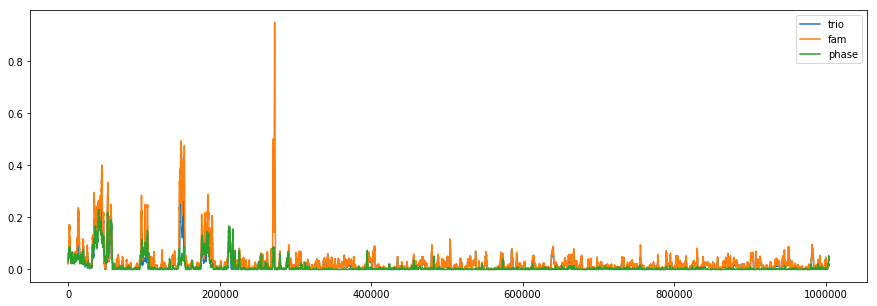

In [107]:
q = 1000

plt.figure(figsize=(15, 5))
plt.plot(np.convolve(1-is_trio_mendelian[i, :], np.ones((q,))/q, mode='same'), label='trio')
plt.plot(np.convolve(1-is_fam_mendelian[i, :], np.ones((q,))/q, mode='same'), label='fam')
plt.plot(np.convolve(1-is_phase_matched[i, :], np.ones((q,))/q, mode='same'), label='phase')

plt.legend()
plt.show()

In [100]:
# print a quick summary of each individual

print('\t'.join(['sample_id', 'trio', 'fam', 'phase', 'error', 'unknown']))
for i in range(m):
    print('\t'.join([sample_ids[i], 
                    '%0.4f' % (1-(np.sum(is_trio_mendelian[i, :])/n)),
                    '%0.4f' % (1-(np.sum(is_fam_mendelian[i, :])/n)),
                    '%0.4f' % (1-(np.sum(is_phase_matched[i, :])/n)),
                    '%0.4f' % (np.sum(is_possible_error[i, :])/n),
                    '%0.4f' % (np.sum(is_unknown[i, :])/n)]))
    

sample_id	trio	fam	phase	error	unknown
AU1043304	0.0205	0.0293	0.0118	0.0032	0.0090
AU2911309	0.0184	0.0483	0.0048	0.0044	0.0085
AU1860301	0.0194	0.0271	0.0087	0.0035	0.0094
AU3154301	0.0166	0.0206	0.0074	0.0042	0.0062
AU3053301	0.0211	0.0289	0.0101	0.0036	0.0087
AU3646301	0.0191	0.0224	0.0045	0.0039	0.0090
AU3846302	0.0208	0.0412	0.0078	0.0038	0.0073
AU3702307	0.0174	0.0271	0.0117	0.0037	0.0110
AU3761302	0.0215	0.0254	0.0068	0.0037	0.0089
AU3913302	0.0199	0.0287	0.0128	0.0040	0.0064
AU3713302	0.0182	0.0224	0.0071	0.0037	0.0073
AU3051303	0.0202	0.0238	0.0051	0.0035	0.0095
AU3839303	0.0191	0.0278	0.0118	0.0038	0.0098
AU4032306	0.0203	0.0342	0.0000	0.0039	0.0077
AU2410302	0.0229	0.0275	0.0085	0.0039	0.0114
AU1308303	0.0206	0.0251	0.0076	0.0032	0.0083
AU4235303	0.0205	0.0298	0.0101	0.0035	0.0090


In [59]:
import matplotlib.pyplot as plt

# now precision recall for trio

#print('\t'.join(['sample_id', 'prec', 'recall']))
trio_prec, trio_recall = [], []
for i in range(m):
    TP = np.sum((~is_trio_mendelian[i, :]) & is_possible_error[i, :])
    FP = np.sum((~is_trio_mendelian[i, :]) & (~is_possible_error[i, :]) & (~is_unknown[i, :]))
    FN = np.sum(is_trio_mendelian[i, :] & is_possible_error[i, :])
    #print('\t'.join([sample_ids[i], 
    #                '%0.4f' % (TP/(TP+FP)),
    #                '%0.4f' % (TP/(TP+FN))]))
    trio_prec.append(TP/(TP+FP))
    trio_recall.append(TP/(TP+FN))    

In [60]:
# now precision recall for fam

#print('\t'.join(['sample_id', 'prec', 'recall']))
fam_prec, fam_recall = [], []
for i in range(m):
    TP = np.sum((~is_fam_mendelian[i, :]) & is_possible_error[i, :])
    FP = np.sum((~is_fam_mendelian[i, :]) & (~is_possible_error[i, :]) & (~is_unknown[i, :]))
    FN = np.sum(is_fam_mendelian[i, :] & is_possible_error[i, :])
    #print('\t'.join([sample_ids[i], 
    #                '%0.4f' % (TP/(TP+FP)),
    #                '%0.4f' % (TP/(TP+FN))]))
    fam_prec.append(TP/(TP+FP))
    fam_recall.append(TP/(TP+FN))

In [63]:
# now precision recall for phase

#print('\t'.join(['sample_id', 'prec', 'recall']))
phase_prec, phase_recall = [], []
for i in range(m):
    TP = np.sum((~is_phase_matched[i, :]) & is_possible_error[i, :])
    FP = np.sum((~is_phase_matched[i, :]) & (~is_possible_error[i, :]) & (~is_unknown[i, :]))
    FN = np.sum(is_phase_matched[i, :] & is_possible_error[i, :])
    #print('\t'.join([sample_ids[i], 
    #                '%0.4f' % (TP/(TP+FP)),
    #                '%0.4f' % (TP/(TP+FN))]))
    phase_prec.append(TP/(TP+FP))
    phase_recall.append(TP/(TP+FN))
    

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


In [70]:
# now precision recall for blame==1

#print('\t'.join(['sample_id', 'prec', 'recall']))
blame_prec, blame_recall = [], []
for i in range(m):
    TP = np.sum((blame_data[i, :] > 0) & is_possible_error[i, :])
    FP = np.sum((blame_data[i, :] > 0) & (~is_possible_error[i, :]) & (~is_unknown[i, :]))
    FN = np.sum((blame_data[i, :] == 0) & is_possible_error[i, :])
    #print('\t'.join([sample_ids[i], 
    #                '%0.4f' % (TP/(TP+FP)),
    #                '%0.4f' % (TP/(TP+FN))]))
    blame_prec.append(TP/(TP+FP))
    blame_recall.append(TP/(TP+FN))
    

17


IndexError: index 16 is out of bounds for axis 0 with size 16

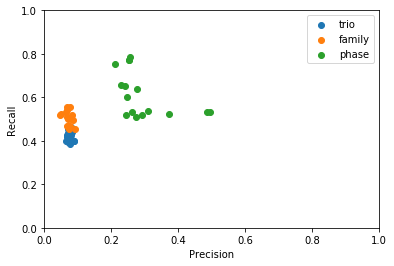

In [62]:
plt.scatter(trio_prec, trio_recall, label='trio')
plt.scatter(fam_prec, fam_recall, label='family')
plt.scatter(phase_prec, phase_recall, label='phase')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()

plt.show()